!pip install python-Levenshtein
!git clone --recursive https://github.com/parlance/ctcdecode.git
!pip install wget
%cd ctcdecode
!pip install .
%cd ..

In [2]:
!pip install tokenizers

     |████████████████████████████████| 1.1 MB 3.9 MB/s eta 0:00:01


In [12]:
import numpy as np
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import * # for pad_sequence and whatnot
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

from torch.utils import data
from torchvision import transforms

import matplotlib.pyplot as plt
import time

import json

from transformers import AutoModel, AutoTokenizer, BertTokenizer, BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
"""
from tokenizers import Tokenizer
from tokenizers.decoders import ByteLevel as ByteLevelDecoder
from tokenizers.models import BPE 
from tokenizers.normalizers import Lowercase, NFKC, Sequence
from tokenizers.pre_tokenizers import ByteLevel
"""
cuda = torch.cuda.is_available()
cuda

False

In [4]:
# To have more information about what's happening under the hood
import logging
logging.basicConfig(level=logging.INFO)

!git clone --recursive https://github.com/parlance/ctcdecode.git
!pip install wget
%cd ctcdecode
!pip install .
%cd ..

### DATA PROCESSING

In [5]:
torch.set_grad_enabled(False)
MODEL_NAME = "bert-base-uncased"

model = AutoModel.from_pretrained(MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /Users/manuelladron/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.8f56353af4a709bf5ff0fbc915d8f5b42bfff892cbb6ac98c3c45f481a03c685
INFO:transformers.configuration_utils:Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
 

In [200]:
ALPHABET = 'abcdefghijklmnopqrstuvwxyz'
NUMBERS = '0123456789'
class PreprocessedData_wordlevel(object):
    def __init__(self, train_file_path, test_file_path):
        """
        train_file_path = list with files
        test_file_path = list with files
        """
        
        self.train_path = train_file_path
        self.test_path = test_file_path
        
        self.VOCAB = None
        self.VOCAB_SIZE = None
                
        # Automatically run it when making an instance
        self.RUN_for_dataset()

    ############ utils #########################
    
    def get_file(self, path):
        with open(path, encoding='utf-8') as f:
            data = json.loads(json.load(f))
        return data
    
    def text_from_json(self, json_file):
        all_text = []
        for file in json_file:
            for sample in file:
                text_l = sample['text']
                for sentence in text_l:
                    sent = sentence.lower()
                    all_text.append(sent)
        return all_text
    

    ############## PROCESSING DATA ##############
    
    def remove_all_letters_in_text_tags_from_alphabet(self, alphabet, positive_tags, all_text):
        """
        Takes in an alphabet, a list of tags and a list of sentences. Returns an alphabet that correspond to the 
        negative samples by substracting the positive tags
        """
        # 1) Get alphabet cropped to the length of sentences
        idx_len = len(all_text)
        cropped_alphabet = alphabet[:idx_len]


        # 2) If not positive tags, return cropped_alpha
        if positive_tags == []:
            return cropped_alphabet

        # 3) Iterate over positive tags and remove them from cropped_alphabet. 
        for tag in positive_tags:
            new_alphabet = cropped_alphabet.replace(tag, "")
            cropped_alphabet = new_alphabet

        # 4) The result is the negative tags! :)
        return new_alphabet

        
    def get_all_text(self, files):
        """
        Parse json file and outputs train_data (text) and numpy array labels for binary classification
        """
        self.sentences = []
        self.sentences_labels = []
        
        for file in files:
            # iterate over the examples in file and grab positive and negative samples
            for i in range(len(file)):
                # elements from dictionary
                positive_tags = file[i]['text-tags']
                text_list = file[i]['text']

                # valid text
                valid_text = [ text_list[ALPHABET.index(letter)].lower() for letter in positive_tags ]

                # nonvalid text
                negative_tags = self.remove_all_letters_in_text_tags_from_alphabet(ALPHABET, positive_tags, text_list)
                nonvalid_text = [ text_list[ALPHABET.index(letter)].lower() for letter in negative_tags ] 
                
                # labels
#                 pos_label = np.array([0,1])
#                 neg_label = np.array([1,0])

                pos_label = np.array([1])
                neg_label = np.array([0])

                # append sentences and labels that are not empty lists
                if len(nonvalid_text) != 0:
                    
                    for nv_text in nonvalid_text:
                        self.sentences.append(nv_text)
                        self.sentences_labels.append(neg_label)

                if len(valid_text) != 0:
                    
                    for v_text in valid_text:
                        self.sentences.append(v_text)
                        self.sentences_labels.append(pos_label)

        # from list to array
        self.sentences_labels = np.array(self.sentences_labels, dtype='int64')

    def tokenize_sentences(self):
        
        # Tokenize all sentences and map the tokens to their word ID 
        self.inputs_ids = []
        self.attention_masks = []
        
        for sent in self.sentences:                
            # `encode_plus` will:
            #   (1) Tokenize the sentence.
            #   (2) Prepend the `[CLS]` token to the start.
            #   (3) Append the `[SEP]` token to the end.
            #   (4) Map tokens to their IDs.
            #   (5) Pad or truncate the sentence to `max_length`
            #   (6) Create attention masks for [PAD] tokens.
            encoded_dict = tokenizer.encode_plus(sent,
                                                add_special_tokens = True, # add [CLS] and [SEP]
                                                max_length = 64,
                                                pad_to_max_length = True,  # pad and truncate
                                                return_attention_mask = True,
                                                return_tensors = 'pt'
                                                )
            self.inputs_ids.append(encoded_dict['input_ids'])
            self.attention_masks.append(encoded_dict['attention_mask'])
            
#             print('original: ', sent)
#             print('token IDs: ', encoded_dict['input_ids'])

        # Convert list to tensors
        self.inputs_ids = torch.cat(self.inputs_ids, dim=0)
        self.attention_masks = torch.cat(self.attention_masks, dim=0)
        self.labels = torch.tensor(self.sentences_labels)
        print(self.labels.shape)
        print(self.labels.type())
    def partition_data(self, train_percentage):
        
        assert len(self.inputs_ids) == len(self.sentences_labels)
        dataset = TensorDataset(self.inputs_ids, self.attention_masks, self.labels)
        
        train_size = int(train_percentage * len(dataset))
        dev_size = len(dataset) - train_size

        
        self.train_dataset, self.dev_dataset = random_split(dataset, [train_size, dev_size])
        
        print('{:>5,} training samples'.format(train_size))
        print('{:>5,} validation samples'.format(dev_size))

    
    def RUN_for_dataset(self):
        
        # 1) get jsons
        train_raw = []
        for i in range(len(self.train_path)): # list with all training data from different sections
            train_raw.append(self.get_file(self.train_path[i]))
        
        # 2) get text
        self.get_all_text(train_raw)
        print(len(self.sentences), len(self.sentences_labels))
        # 3) tokenize at word-level
        self.tokenize_sentences()
        
        # 4) partition data
        self.partition_data(.8)

In [201]:
dataset = PreprocessedData_wordlevel(["./data/architecture_dz-cleaned-tagged.json",
                            "./data/design_dz-cleaned-tagged.json",
                           "./data/technology_dz-cleaned-tagged.json", ], 
                           ["./data/architecture_dz-cleaned.json", 
                            "./data/design_dz-cleaned.json",
                           "./data/technology_dz-cleaned.json"])

9628 9628
torch.Size([9628, 1])
torch.LongTensor
7,702 training samples
1,926 validation samples


In [202]:
train_dataset = dataset.train_dataset
dev_dataset = dataset.dev_dataset

### Dataloader

In [214]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

device = torch.device("cuda" if cuda else "cpu")
print(device)
num_workers = 8 if cuda else 0 

# Create the DataLoaders for our training and validation sets.

# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            dev_dataset, # The validation samples.
            sampler = SequentialSampler(dev_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )


cpu


In [215]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.to(device)

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /Users/manuelladron/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.8f56353af4a709bf5ff0fbc915d8f5b42bfff892cbb6ac98c3c45f481a03c685
INFO:transformers.configuration_utils:Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
 

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [216]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

### Hyperparameters

In [217]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Training:

- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass.
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

Evalution:

- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress


In [218]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [219]:
import time
import datetime
import random

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [221]:
def make_graph(epochs, train, test, train_name, val_name, name_long, name_short):
    BCK = (3/255, 5/255, 25/255)
    fig, ax = plt.subplots()
    ax.set_facecolor(BCK)
    ax.plot(epochs, train, 'g', label=train_name, c="mediumvioletred")
    ax.plot(epochs, test, 'b', label=val_name, c="darkturquoise")
    ax.set_title(name_long)
    ax.set_xlabel('Epochs')
    ax.set_ylabel(name_short)
    ax.legend()
    plt.show()

In [246]:
def train(model, loader, optimizer, scheduler):
    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.

    running_loss = 0.0
    running_acc = 0.0
    
    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(loader):
        
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)  # batch x seq_length
        b_input_mask = batch[1].to(device) # batch x seq_length
        b_labels = batch[2].to(device)     # batch x 2 (num_classes, binary)

#         print("inputs_ids shape: ", b_input_ids.shape)
#         print("input_mask shape: ", b_input_mask.shape)
#         print("labels shape: ", b_labels.shape)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        loss = loss.clone().detach().requires_grad_(True)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        running_loss += loss.item()
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        
        accuracy = flat_accuracy(logits, b_labels)
        running_acc += accuracy
        
        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    running_loss /= len(loader)
    running_acc /= len(loader)
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(running_loss))
    print("  Training epcoh took: {:}".format(training_time))
    return running_loss, running_acc, training_time

In [247]:
def test(model, loader):
    
    t0 = time.time()
    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    running_loss = 0
    running_acc = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in loader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, # bc of single sentences?
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        running_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        running_acc += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    running_acc /= len(validation_dataloader)
    

    # Calculate the average loss over all of the batches.
    running_loss /= len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(running_loss))
    print("  Validation Accuracy: {0:.2f}".format(running_acc))
    print("  Validation took: {:}".format(validation_time))

    return running_loss, running_acc, validation_time

In [257]:
def run_epochs(model, train_dataloader, validation_dataloader, optimizer, scheduler, epochs):
    # This training code is based on the `run_glue.py` script here:
    # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

    # Set the seed value all over the place to make this reproducible.
    seed_val = 42

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    # We'll store a number of quantities such as training and validation loss, 
    # validation accuracy, and timings.
    training_stats = []

    # Measure the total training time for the whole run.
    total_t0 = time.time()

    train_losses, train_accs = [], []
    test_losses, test_accs = [] , []
    epochs_l = []
    # For each epoch...
    for epoch_i in range(0, epochs):

        # ========================================
        #               Training
        # ========================================

        # Perform one full pass over the training set.

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        train_loss, train_acc, train_time = train(model, train_dataloader, optimizer, scheduler)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        print("")
        print("Running Validation...")
        
        test_loss, test_acc, test_time = test(model, validation_dataloader)
        test_losses.append(test_loss)
        test_accs.append(test_acc)


        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': train_loss,
                'Training Accur.': train_acc,
                'Valid. Loss': test_loss,
                'Valid. Accur.': test_acc,
                'Training Time': train_time,
                'Validation Time': test_time
            }
        )

        # Epochs
        epochs_l.append(epoch_i)
        
        # Draw Graphs
        print("list of epochs: ")
        print("train_accs, test_accs: ", train_accs, test_accs)
        print("train_losses, test_losses: ", train_losses, test_losses)
        make_graph(epochs_l, train_losses, test_losses, 'Training loss', 'Testing loss',
                       'Training and Testing loss', 'Loss')
        make_graph(epochs_l, train_accs, test_accs, 'Training Acc', 'Testing Acc',
                       'Training and Testing Accuracy', 'Accuracy')

       

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
    return train_losses, train_accs, test_losses, test_accs


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:01:14.
  Batch    80  of    241.    Elapsed: 0:02:33.
  Batch   120  of    241.    Elapsed: 0:03:50.
  Batch   160  of    241.    Elapsed: 0:05:07.
  Batch   200  of    241.    Elapsed: 0:06:30.
  Batch   240  of    241.    Elapsed: 0:07:47.

  Average training loss: 0.91
  Training epcoh took: 0:07:48

Running Validation...
  Validation Loss: 0.92
  Validation Accuracy: 0.38
  Validation took: 0:01:44
list of epochs: 
train_accs, test_accs:  [0.0] [0.381318306010929]
train_losses, test_losses:  [0.9084275688867846] [0.9237584461931323]


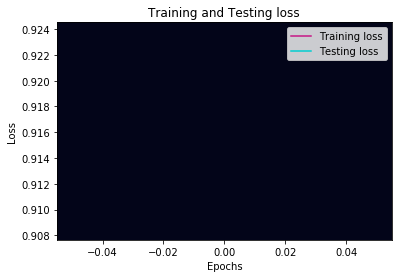

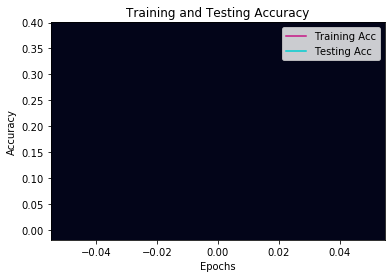


======== Epoch 2 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:01:15.
  Batch    80  of    241.    Elapsed: 0:02:29.
  Batch   120  of    241.    Elapsed: 0:03:44.
  Batch   160  of    241.    Elapsed: 0:04:58.
  Batch   200  of    241.    Elapsed: 0:06:12.
  Batch   240  of    241.    Elapsed: 0:07:27.

  Average training loss: 0.91
  Training epcoh took: 0:07:28

Running Validation...
  Validation Loss: 0.92
  Validation Accuracy: 0.38
  Validation took: 0:01:42
list of epochs: 
train_accs, test_accs:  [0.0, 0.0] [0.381318306010929, 0.381318306010929]
train_losses, test_losses:  [0.9084275688867846, 0.9082840737960151] [0.9237584461931323, 0.9237584461931323]


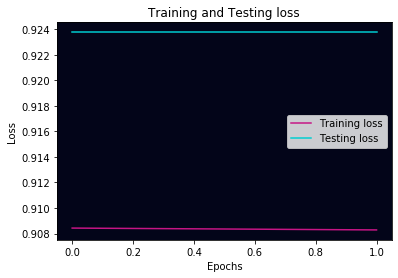

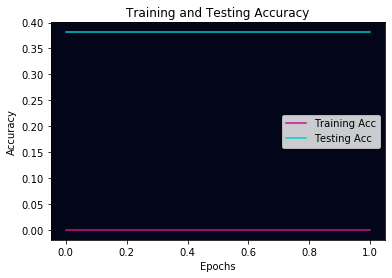


======== Epoch 3 / 4 ========
Training...


In [ ]:
train_losses, train_accs, test_losses, test_accs = run_epochs(model, train_dataloader, validation_dataloader, optimizer, scheduler, epochs)